# Data prediction

#### Import libraries

In [64]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np 
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from scipy import stats

import pandas as pd 
from xgboost import XGBClassifier


#### Load data

In [21]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df = df.drop('id', axis=1)

## Data preparation

#### Use Decision tree to fill in missing values based on age and gender

In [22]:
bmiPipe = Pipeline(steps=[('scale',StandardScaler()),
                    ('lr',DecisionTreeRegressor())
                    ])
X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

missingDF = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
bmiPipe.fit(X,Y)
predictedBMI = pd.Series(bmiPipe.predict(missingDF[['age','gender']]), index=missingDF.index)
df.loc[missingDF.index, 'bmi'] = predictedBMI

#### Change categorical variables to binary values

In [23]:
df.gender = df.gender.replace({'Male':0,'Female':1, 'Other':-1}).astype(np.uint8)
df.ever_married = df.ever_married.replace({'No':0, 'Yes':1}).astype(np.uint8)
df.Residence_type = df.Residence_type.replace({'Urban':0, 'Rural':1}).astype(np.uint8)

In [24]:
toDummies = ['work_type', 'smoking_status']
df = pd.get_dummies(df, columns=toDummies, prefix='', prefix_sep='')

#### Set features and targets

In [25]:
Y = df['stroke']
X = df.drop('stroke', axis=1)

#### Oversample data as we have imbalanced data set

In [26]:
ros = RandomOverSampler(sampling_strategy = 0.5)
x_res, y_res = ros.fit_resample(X, Y)
y_res.value_counts()

0    4861
1    2430
Name: stroke, dtype: int64

#### Prepare data for training

In [27]:
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=123)

In [29]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

## XGBoost classifier

#### Set parameters and train model

In [30]:
parameters = {
        'n_estimators': stats.randint(100, 1250),
        'learning_rate': stats.uniform(0.01, 1),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6, 7, 8, 9, 10]
        }

XGB = XGBClassifier()

# Choose best parameters
RS1 = RandomizedSearchCV(XGB, param_distributions=parameters, n_iter=5, n_jobs=-2, cv=5, verbose=4, random_state=123)

RS1.fit(train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:33:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                  

#### Predict on test data

In [31]:
xgbPrediction1 = RS1.best_estimator_.predict(test_scaled)

#### Calculate accuracy

In [32]:
xgbAcc1 = accuracy_score(y_test, xgbPrediction)
xgbAcc1

0.9766963673749143

#### Populate confusion matrix

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


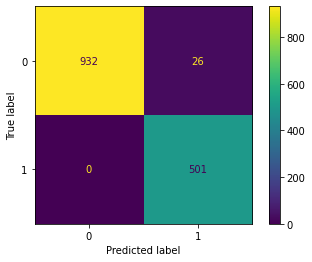

In [33]:
plot_confusion_matrix(RS1.best_estimator_, test_scaled, y_test)

plt.show()

#### Get best parameters

In [34]:
print(f'Best parameters: {RS1.best_params_}')

Best parameters: {'colsample_bytree': 0.8, 'gamma': 2, 'learning_rate': 0.25475927695391987, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1192, 'subsample': 0.8}


#### Populate graf with feature importance

<AxesSubplot:>

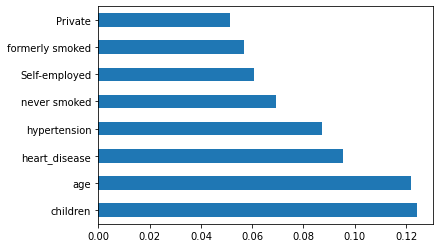

In [35]:
(pd.Series(RS1.best_estimator_.feature_importances_, index=X.columns).nlargest(8).plot(kind='barh'))

## MLP Classifier

#### Set parameters and train data

In [36]:
MLP = MLPClassifier(max_iter=50)

parameters = {
    'hidden_layer_sizes': [(75,75,75), (75,125,75), (125,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Choose best parameters
GSCV1 = GridSearchCV(MLP, parameters, n_jobs=-1, cv=3)

GSCV1.fit(train_scaled, y_train)

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(75, 75, 75), (75, 125, 75),
                                                (125,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

#### Predict on test data

In [37]:
mlpPrediction1 = GSCV1.predict(test_scaled)

#### Calculate accuracy

In [39]:
mlpAcc1 = accuracy_score(y_test, mlpPrediction1)
mlpAcc1

0.9410555174777244

#### Populate confusion matrix

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


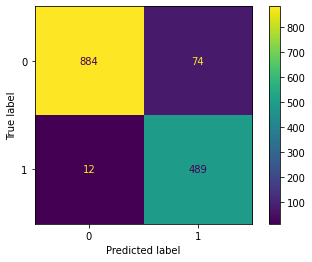

In [40]:
plot_confusion_matrix(GSCV1, test_scaled, y_test)
plt.show()

#### Get best parameters

In [41]:
print(f'Best parameters: {GSCV1.best_params_}')

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (75, 125, 75), 'learning_rate': 'adaptive', 'solver': 'adam'}


## New models with only the most important features

#### Create new df

In [42]:
bestDf = df[['age', 'ever_married', 'heart_disease', 'never smoked', 'smokes', 'Self-employed', 'Private', 'hypertension', 'stroke']]

#### Prepare data for training

In [43]:
Y = bestDf['stroke']
X = bestDf.drop('stroke', axis=1)

In [44]:
ros = RandomOverSampler(sampling_strategy = 0.5)
x_res, y_res = ros.fit_resample(X, Y)
le = preprocessing.LabelEncoder()
X = X.apply(le.fit_transform)
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=123)
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

## XGBoost Classifier

#### Set parameters and train model

In [45]:
parameters = {
        'n_estimators': stats.randint(100, 1250),
        'learning_rate': stats.uniform(0.01, 1),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0, 2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6, 7, 8, 9, 10]
        }

XGB = XGBClassifier()

# Choose best parameters
RS2 = RandomizedSearchCV(XGB, param_distributions=parameters, n_iter=5, n_jobs=-2, cv=5, verbose=4, random_state=123)

RS2.fit(train_scaled, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                  

#### Predict on test data

In [46]:
xgbPrediction2 = RS2.best_estimator_.predict(test_scaled)

#### Calculate accuracy

In [47]:
xgbAcc2 = accuracy_score(y_test, xgbPrediction2)
xgbAcc2

0.9026730637422893

#### Populate confusion matrix

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


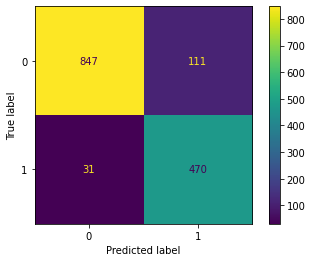

In [48]:
plot_confusion_matrix(RS2.best_estimator_, test_scaled, y_test)

plt.show()

#### Get best parameters

In [49]:
print(f'Best parameters: {RS2.best_params_}')

Best parameters: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.6948297385848633, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1042, 'subsample': 0.6}


#### Populate graf with feature importance

<AxesSubplot:>

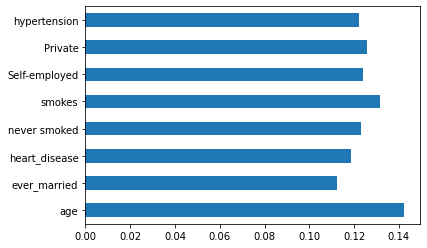

In [50]:
(pd.Series(RS2.best_estimator_.feature_importances_, index=X.columns).plot(kind='barh'))

## MLP Classifier

#### Set parameters and train data

In [51]:
MLP = MLPClassifier(max_iter=50)

parameters = {
    'hidden_layer_sizes': [(75,75,75), (75,125,75), (125,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Choose best parameters
GSCV2 = GridSearchCV(MLP, parameters, n_jobs=-1, cv=3)

GSCV2.fit(train_scaled, y_train)

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=50), n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(75, 75, 75), (75, 125, 75),
                                                (125,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

#### Predict on test data

In [52]:
mlpPrediction2 = GSCV2.predict(test_scaled)

#### Calculate accuracy

In [53]:
mlpAcc2 = accuracy_score(y_test, mlpPrediction2)
mlpAcc2

0.8122001370801919

#### Populate confusion matrix

C:\Users\aheldes\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


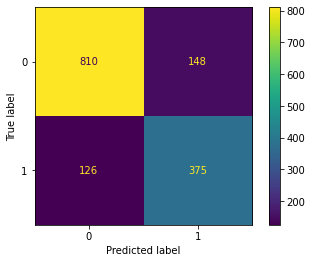

In [54]:
plot_confusion_matrix(GSCV2, test_scaled, y_test)
plt.show()

#### Get best parameters

In [55]:
print(f'Best parameters: {GSCV2.best_params_}')

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (75, 75, 75), 'learning_rate': 'constant', 'solver': 'adam'}


## Compare accuracies of created models

In [56]:
print(f"Accuracy of XGBoost classifier before feature optimization is: {round(xgbAcc1, 2)}")
print(f"Accuracy of MLP classifier before feature optimization is: {round(mlpAcc1, 2)}")
print(f"Accuracy of XGBoost classifier after feature optimization is: {round(xgbAcc2, 2)}")
print(f"Accuracy of MLP classifier after feature optimization is: {round(mlpAcc2, 2)}")

Accuracy of XGBoost classifier before feature optimization is: 0.98
Accuracy of MLP classifier before feature optimization is: 0.94
Accuracy of XGBoost classifier after feature optimization is: 0.9
Accuracy of MLP classifier after feature optimization is: 0.81


In [62]:
def buildROC(target, test):
    fpr, tpr, threshold = roc_curve(target, test)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

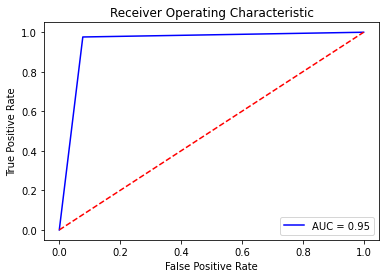

In [65]:
buildROC(y_test, mlpPrediction1)

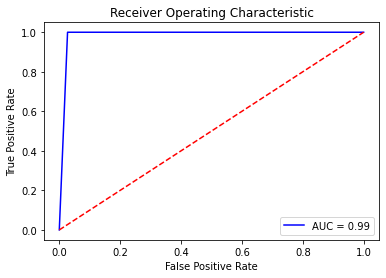

In [59]:
buildROC(y_test, xgbPrediction1)

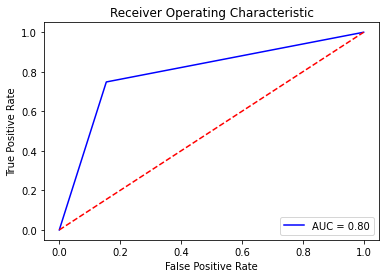

In [60]:
buildROC(y_test, mlpPrediction2)

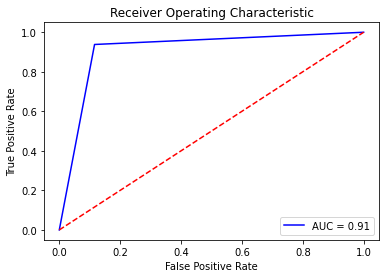

In [61]:
buildROC(y_test, xgbPrediction2)

## Conclusion

Based on the trained models, the best model is XGBoost clasifier with all features. This model has accuracy 0.98. We had to oversample the data as the data set was unbalanced and fill in missing values for BMI using age and gender.